## Final Project Submission

Please fill out:
* Student name: **Dennis Trimarchi**
* Student pace: **full time**
* Scheduled project review date/time: **Not yet scheduled**
* Instructor name: **Rafael Cassaro**
* Blog post URL: **Not yet created**

This file: **Student_3_EDA_Model.jpynb**

# Modeling

This is where my model is created.

### Import a bunch of libraries

There are a bunch of libraries that are used in this project. They are imported and aliased below.

In [423]:
#Datarames and Computation
import numpy as np
import pandas as pd

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
#contexts available: poster, paper, talk, notebook
sns.set_context('paper')

#STATSMODELS

#statistical analysis & regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

#SCIKIT LEARN

#metrics
from sklearn.metrics import mean_squared_error

#linear regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

#label encoding
#from sklearn.preprocessing import LabelEncoder
#lb_make = LabelEncoder()

#create dummy variables
#from sklearn.preprocessing import LabelBinarizer
#lb_bin = LabelBinarizer()

#recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

#train test split
from sklearn.model_selection import train_test_split

#k-fold cross validation
from sklearn.model_selection import cross_val_score

#PICKLE for saving objects
import pickle

#### Read in DataFrame from pickle file

In [411]:
with open('data.pickle','rb') as f:
    data = pickle.load(f)
    
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,lat,sqft_living15,sqft_lot15,has_basement,built_last_20_yrs,dist_from_Bellvue,log_dist_from_Bellvue
count,2.096300e+04,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000
mean,5.154048e+05,3.355102,2.108858,2032.599389,10750.234270,1.488360,0.004675,7.614607,1749.281925,47.560797,1962.964080,9979.023184,0.383247,0.257501,11.345828,2.276608
std,2.830298e+05,0.879990,0.728166,834.998842,13638.141655,0.539631,0.068215,1.119503,769.590305,0.138196,662.339591,11795.111734,0.486189,0.437268,6.105843,0.586817
min,7.800000e+04,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,3.000000,370.000000,47.155900,460.000000,651.000000,0.000000,0.000000,0.143320,-1.942678
25%,3.200000e+05,3.000000,1.500000,1410.000000,5000.000000,1.000000,0.000000,7.000000,1180.000000,47.472750,1480.000000,5054.000000,0.000000,0.000000,7.132481,1.964659
50%,4.470000e+05,3.000000,2.000000,1890.000000,7500.000000,1.500000,0.000000,7.000000,1540.000000,47.571900,1820.000000,7536.000000,0.000000,0.000000,9.934962,2.296060
75%,6.300000e+05,4.000000,2.500000,2500.000000,10275.000000,2.000000,0.000000,8.000000,2160.000000,47.678850,2330.000000,9870.000000,1.000000,1.000000,13.803740,2.624940
max,1.990000e+06,7.000000,5.000000,5990.000000,149410.000000,3.500000,1.000000,13.000000,5990.000000,47.777600,5790.000000,149410.000000,1.000000,1.000000,41.355951,3.722216


## Look at Correlations again
Correlations and Heatmap

In [412]:
correlations = data.corr()
correlations['price'].sort_values(ascending=False)

price                    1.000000
grade                    0.674132
sqft_living              0.671363
sqft_living15            0.598063
sqft_above               0.572003
bathrooms                0.488452
lat                      0.373699
bedrooms                 0.321556
floors                   0.274029
has_basement             0.178310
waterfront               0.145956
built_last_20_yrs        0.128341
sqft_lot                 0.120031
sqft_lot15               0.111745
dist_from_Bellvue       -0.487335
log_dist_from_Bellvue   -0.513302
Name: price, dtype: float64

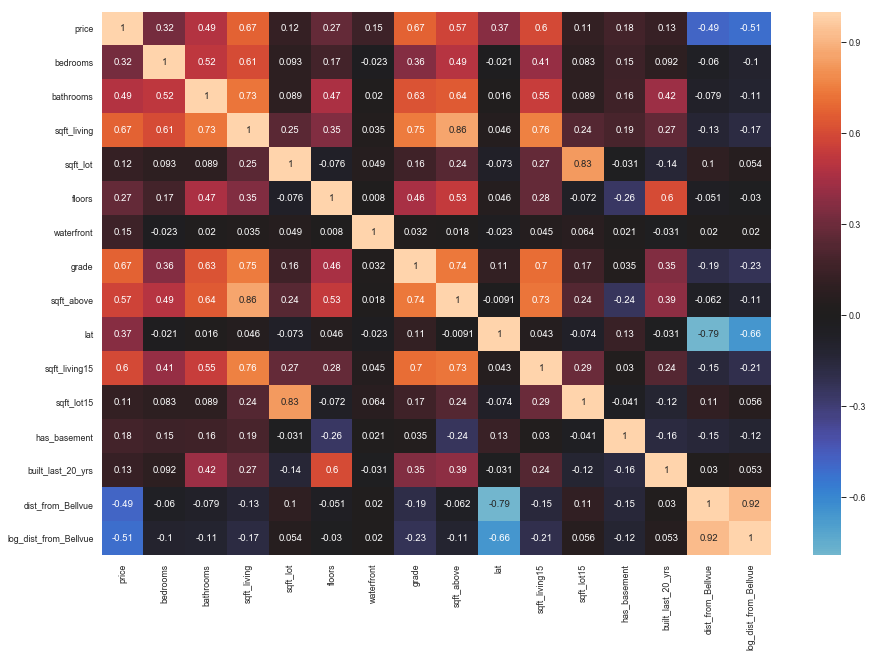

In [413]:
plt.figure(figsize=(15,10))
sns.heatmap(correlations, center=0, annot=True)

### Collinearity

There is a collinearity mess as can be seen in the heatmap. There are three groups of collinear features. Plans on how to deal with them are shown below.

**collinear groups**

- **Group 1**
  - Features
    - sqft_living
    - sqft_living15
    - sqft_above
    - bedrooms
    - bathrooms
    - grade
  - Plan
    - Drop sqft_above. It is basically the same thing as sqft_living
    - Drop sqft_living15. Highly correlated with sqft_living. Not sure that it adds much.

- **Group 2**
  - Features
    - sqft_lot
    - sqft_lot15
  - Plan
    - Drop sqft_lot15 - doesn't add much. Slightly lower correlation with price.
  
- **Group 3**
  - Features
    - lat
    - dist_from_Bellvue
    - log_dist_from_Bellvue
  - Plan
    - Pick one. Will see which one impacts the model the best through feature ranking.


In [414]:
#Initial feature drops based on discussion above.
data = data.drop(['sqft_living15','sqft_above','sqft_lot15'], axis=1)

# Create the Model

## Train / Test Split before modeling

First split the data into a training set and test set.

In [522]:
#y is the target df
y = data['price']

#features_df is the dataframe of the features
features_df = data.drop(['price'], axis=1)

#These are my training and test sets of data.
X_train, X_test, y_train, y_test = train_test_split(features_df,data['price'],test_size=0.2)

## Selecting Features

### Feature Ranking 

Used scikit learn feature ranking to see which features give the best p-values. This uses the training set of data.

In [525]:
#Feature ranking with scikit learn
#selector = RFECV(linreg, step=1, min_features_to_select=1, cv='warn', scoring=None, verbose=0, n_jobs=None)
selector = RFE(linreg, n_features_to_select=1)
selector = selector.fit(X_train,y_train)
estimators = selector.estimator_

#Store the results or feature ranking into a list of tuples. Then sort them by rank.
features_ranked = zip(X_train.columns,selector.ranking_)
sorted_features = sorted(features_ranked, key=lambda tup: tup[1])

#Iterate through sorted features and print their rank
for col, rank in sorted_features:
    print("{}. {}".format(rank,col))


1. waterfront
2. log_dist_from_Bellvue
3. lat
4. grade
5. bathrooms
6. built_last_20_yrs
7. has_basement
8. floors
9. bedrooms
10. dist_from_Bellvue
11. sqft_living
12. sqft_lot


Feature Ranking with Recursive Feature Elimination shows ranked features:

1. waterfront
2. log_dist_from_Bellvue
3. lat
4. grade
5. built_last_20_yrs
6. bathrooms
7. has_basement
8. floors
9. bedrooms
10. dist_from_Bellvue
11. sqft_living
12. sqft_lot

I decided to use this information in order to help determine features during my OLS tests. Funny enough, after playing around with the OLS regressions, I decided not to follow the feature elimination results.

### Run an OLS Regression with the selected features.

I ran the regression below multiple times with different features removed. 

1. All features: When every feature was included, adj R^2 = 0.688 but there were a bunch of collinear features.

2. Removed all lowest ranked collinear features *bathrooms, bedrooms, sqft_living, dist_from_Bellvue, lat*: adj R^2 = 0.622. All p-values are less than 0.05.

3. Removed *waterfront*: adj R^2 = 0.606. Even though I think this is an important feature, the data size is so small that I want to take it out of the model for now.

4. Swapped out *grade* with *sqft_living*: I feel that sqft_living is more generic since grade depends on the county rating system. p-value for *sqft_lot* went up to 0.602 and adj R^2 = 0.620.

5. Removed *sqft_lot* because of p-value: adj R^2 is still 0.620.

6. Removed *has_basement*: adj R^2 only changed to 0.619.

7. Removed *built_last_20_yrs*: adj R^2 only changed to 0.617

8. Added back in *built_last_20_yrs* and removed *floors*: adj R^2 = 0.614

9. Removed *built_last_20_yrs* again: adj R^2 = 0.614 no change.

10. Swapped *log_dist_from_Bellvue* for *dist_from_Bellvue*: I like that the latter is not transformed. adj R^2 = 0.614. No change.

11. Added back in *waterfront*: adj R^2 = 0.631. Even better than the first non-collinear model.

12. Removed *waterfront*: adj R^2 = 0.614 again. Alas, I still wasn't comfortable including it.

13. Swapped back *log_dist_from_Bellvue* in place of *dist_from_Bellvue*: I do not like that dist_from_Bellvue has a greater negative impact for distances far away from Bellvue than the log version: adj R^2 = 0.614. No change there.


**Ended up with sqft_living, dist_from_Bellvue as the two predictors**


In [574]:
#Regression is run on the training set of data.

#List of features being dropped - changed list many times throughout model development.
features_dropped = ['waterfront','grade','lat','bathrooms','bedrooms','dist_from_Bellvue',
                    'sqft_lot','has_basement','floors','built_last_20_yrs']

#OLS Regression and Model summary
X_ols = X_train.drop(features_dropped, axis=1)
X_int = sm.add_constant(X_ols)
model = sm.OLS(y_train,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.335e+04
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:14:11   Log-Likelihood:            -2.2621e+05
No. Observations:               16770   AIC:                         4.524e+05
Df Residuals:                   16767   BIC:                         4.525e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.503e+05   6857.889     80.248      0.000    5.37e+05    5.64e+05
sqft_living             202.7969      1.642    123.512      0.000     199.579     206.015
log_dist_from_Bellvue -1.968e+05   2327.539    -84.531      0.000   -2.01e+05   -1.92e+05
==============================================================================
Omnibus:                     5273.290   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25274.339
Skew:                           1.454   Prob(JB):                         0.00
Kurtosis:                       8.264   Cond. No.                     1.17e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

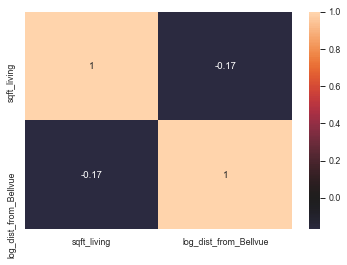

In [569]:
#Look at correlations again
correlations = X_ols.corr()
plt.figure(figsize=(6,4))
sns.heatmap(correlations, center=0, annot=True)

### Compare RMSE for training and test sets

Need to drop the unused features from the X_train and X_test DataFrames. Now that I've settled on a couple features.

In [575]:
#Need to drop unused features from original X_train and X_test sets.
X_training = X_train.drop(features_dropped, axis=1)
X_testing = X_test.drop(features_dropped, axis=1)

In [576]:
#Need to run linreg in scikit learn first
linreg.fit(X_training,y_train)
linreg.coef_, linreg.intercept_

(array([    202.79693461, -196750.18592147]), 550330.9625449341)

The coefficients from scikit learn and the OLS model match. This is promising.

In [578]:
#Compare train and test set predictions
y_hat_train = linreg.predict(X_training)
y_hat_test = linreg.predict(X_testing)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

MSE_train = np.mean(train_residuals**2)
MSE_test = np.mean(test_residuals**2)

RMSE_train = MSE_train**0.5
RMSE_test = MSE_test**0.5

print("MSE train: {:0.0f}  RMSE train: {:0.0f}".format(MSE_train, RMSE_train))
print("MSE test:  {:0.0f}  RMSE test:  {:0.0f}".format(MSE_test, RMSE_test))

MSE train: 30481264291  RMSE train: 174589
MSE test:  32681703807  RMSE test:  180781


#### Normality of Residuals


Looks mostly like a normal distribution of residuals. However, the QQ plot has some weird non-normality to it. 

I believe that the skew has to do with the skew in the original dataset for price. The normal distribution for price has a long tail in the expensive direction. The model will not properly provide estimates for these types of properties and will under-predict, resulting in more negative residuals as shown below.

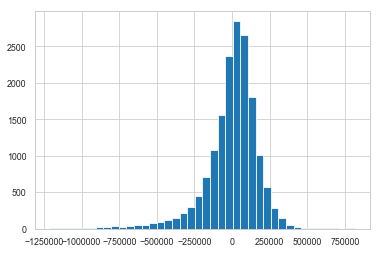

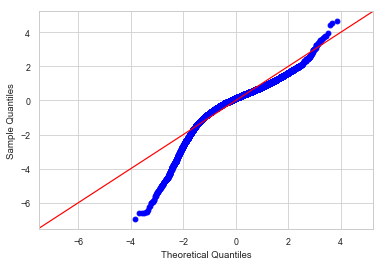

In [579]:
plt.hist(train_residuals, bins=40);

sm.graphics.qqplot(train_residuals,dist=stats.norm,line='45',fit=True)
plt.show()

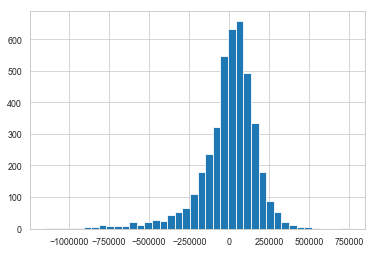

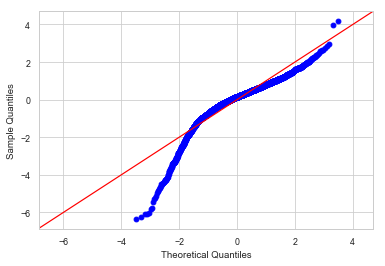

In [580]:
plt.hist(test_residuals, bins=40);

sm.graphics.qqplot(test_residuals,dist=stats.norm,line='45',fit=True)
plt.show()

#### K-Fold Cross Validation

In [594]:
#K-FOLD Cross Validation
features_in_model_df = features_df.drop(features_dropped,axis=1)

cv_5_results = cross_val_score(linreg,features_in_model_df,y,cv=5,scoring='neg_mean_squared_error')

cv_mean = np.mean(cv_5_results)

print("Cross Validation 5 divisions\nMSE:  {:0.0f}\nRMSE: {:0.0f}".format(-cv_mean,(-cv_mean)**0.5))
(-cv_5_results)

Cross Validation 5 divisions
MSE:  30986770902
RMSE: 176031


array([3.10585843e+10, 3.06745899e+10, 3.15275034e+10, 3.23221739e+10,
       2.93510030e+10])

In [595]:
features_in_model_df.head()

,sqft_living,log_dist_from_Bellvue
0,1180,2.267604
1,2570,2.196625
2,770,2.014428
3,1960,2.578489
4,1680,1.792215


Initial OLS Model with all of the features

In [299]:
#Regression is run on the training set of data.

#X_ols = X_train.drop(['waterfront','bedrooms','bathrooms','sqft_lot','sqft_living','floors','lat','dist_from_Bellvue'], axis=1)
X_ols = X_train
X_int = sm.add_constant(X_ols)
model = sm.OLS(y_train,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     2699.
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:37:46   Log-Likelihood:            -1.9318e+05
No. Observations:               14805   AIC:                         3.864e+05
Df Residuals:                   14793   BIC:                         3.865e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.253e+07   5.47e+05    -22.890      0.000   -1.36e+07   -1.15e+07
bedrooms              -1.151e+04   1391.619     -8.271      0.000   -1.42e+04   -8782.928
bathrooms             -5636.9090   2070.560     -2.722      0.006   -9695.464   -1578.354
sqft_living             103.8751      2.314     44.899      0.000      99.340     108.410
sqft_lot                  0.3407      0.073      4.652      0.000       0.197       0.484
floors                 8614.7619   2238.571      3.848      0.000    4226.884     1.3e+04
waterfront             2.927e+05   1.99e+04     14.683      0.000    2.54e+05    3.32e+05
grade                  5.606e+04   1406.271     39.865      0.000    5.33e+04    5.88e+04
lat                    2.655e+05   1.15e+04     23.116      0.000    2.43e+05    2.88e+05
has_basement           1.722e+04   2183.805      7.885      0.000    1.29e+04    2.15e+04
dist_from_Bellvue     -2582.8274    521.398     -4.954      0.000   -3604.832   -1560.823
log_dist_from_Bellvue -8.638e+04   4666.408    -18.512      0.000   -9.55e+04   -7.72e+04
==============================================================================
Omnibus:                     1371.443   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2024.772
Skew:                           0.722   Prob(JB):                         0.00
Kurtosis:                       4.095   Cond. No.                     1.02e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Function that I made in student notebook 1. It gives a lmplot and histogram for a feature.

In [397]:
#define a function that will provide a couple plots for a feature - histogram and scatter
def feature_plots(feature,target,df):
    """
    Creates a histogram of the desired feature and a scatter plot of the target vs. the feature.
    feature = feature (column) name.
    target = target (column) name.
    df = dataframe containing both the feature and target
    returns nothing
    """
    #Print feature name to screen
    print(feature)
    
    #Histogram using sns distplot
    plt.title("{} histogram".format(feature))
    sns.distplot(df[feature])
    plt.show()
    
    #Scatter Plot using sns lmplot
    #plt.figure(figsize=(10,6))
    sns.lmplot(x=feature, y=target, data=df, line_kws={'color': 'red'}, size=7)
    plt.title("{} vs {}".format(target, feature))
    plt.show()
    
    pass

## Removed properties over 1 million

Checking how it impacted model

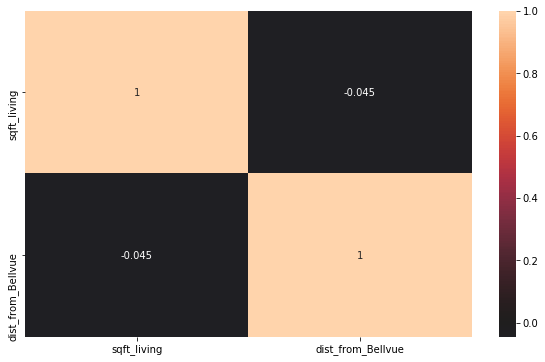

In [327]:
correlations = X_ols.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlations, center=0, annot=True)

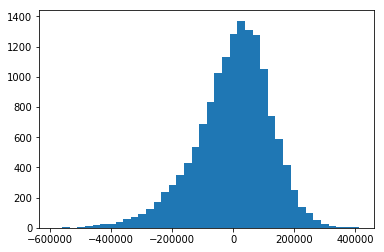

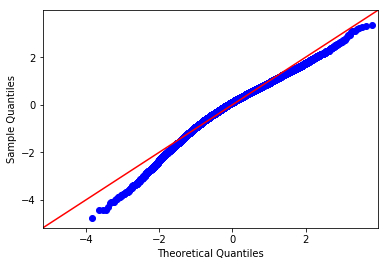

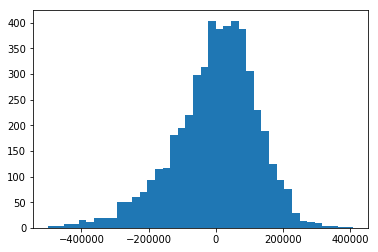

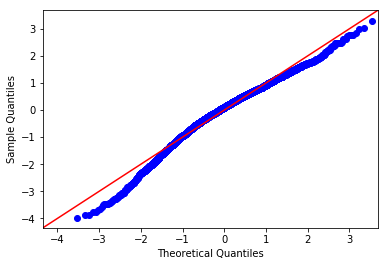

In [328]:
#Train and test residuals
plt.hist(train_residuals, bins=40);

sm.graphics.qqplot(train_residuals,dist=stats.norm,line='45',fit=True)
plt.show()

plt.hist(test_residuals, bins=40);

sm.graphics.qqplot(test_residuals,dist=stats.norm,line='45',fit=True)
plt.show()

In [329]:
#Regression results
#Regression is run on the training set of data.

#List of features being dropped - changed list many times.
features_being_dropped = ['floors','sqft_lot','lat','bathrooms','bedrooms','log_dist_from_Bellvue','grade','has_basement']

#OLS Regression and Model summary
X_ols = X_train.drop(features_being_dropped, axis=1)
X_int = sm.add_constant(X_ols)
model = sm.OLS(y_train,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     7619.
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:40:49   Log-Likelihood:            -1.9440e+05
No. Observations:               14805   AIC:                         3.888e+05
Df Residuals:                   14801   BIC:                         3.888e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.573e+05   3463.392    103.159      0.000     3.5e+05    3.64e+05
sqft_living         150.4679      1.349    111.504      0.000     147.823     153.113
waterfront          3.01e+05   2.27e+04     13.269      0.000    2.57e+05    3.45e+05
dist_from_Bellvue -1.589e+04    164.966    -96.340      0.000   -1.62e+04   -1.56e+04
==============================================================================
Omnibus:                      889.086   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.409
Skew:                           0.572   Prob(JB):                    1.89e-249
Kurtosis:                       3.739   Cond. No.                     4.71e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""